# Assignment One (CS 7180)

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 0. Package Versions

In [2]:
print("Python version: {}\n".format(sys.version))
print("Numpy version: {}".format(np.__version__))
print("Torch version: {}".format(torch.__version__))
print("Torchvision version: {}\n".format(torchvision.__version__))

Python version: 3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]

Numpy version: 1.14.5
Torch version: 0.4.1
Torchvision version: 0.2.1



In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Tesla K80


### 1. Load Data

In [4]:
# 1. Load MNIST training and test data from torchvision.datasets.MNIST.
# 2. Please use data.DataLoader and print out dataset size, sample size, batch size.
#******************************#

print("Transformation on MNIST: \n\n{}\n".format(transforms.ToTensor().__doc__))

transform = transforms.Compose(
    [transforms.ToTensor()]) 

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                               transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#******************************#

Transformation on MNIST: 

Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.

    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    



### 2. Define Hyper-parameters

In [5]:
# Define hyper-parameters
#******************************#

num_classes = 10

hyperparams = {
    "batch_size"       : 32,
    "test_batch_size"  : 1000,
    "epochs"           : 10,
    "learning_rate"    : 0.001,
    "momentum"         : 0.9,
    "random_seed"      : 42,
    
    # Params related to reporting
    
    "log_interval"     : 10000,
}

#******************************#

### 3. Define a Convolutional Neural Network

In [6]:

class ConvNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.0):
        super(ConvNet, self).__init__()
        # 3.1 Initialization
        #******************************#
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 75, 5, 1),
            nn.BatchNorm2d(75),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(4*4*75, 500)
        self.fc2 = nn.Linear(500, 10)
        #******************************#
    def forward(self, x):
        # 3.2 Define Neural Network
        #******************************#
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #******************************#
        return out
    
    def count_params(self):
        pytorch_total_params = sum(p.numel() for p in super(ConvNet, self).parameters())
        return pytorch_total_params

# Note: what is the difference between 'same' and 'valid' padding? 
# Take a look at the outputs to understand the difference.

### 4. Training the Model

In [7]:
# Training and testing functions

def performance(result_metrics: tuple, epoch: int, pmeta: list, set_type: str, print_result=True):
    meta = {
        "set_type": None,
        "epoch": None,
        "n_correct": None,
        "loss": None,
        "n_instances": None,
    }
    loss, n_correct, n_instances = result_metrics
    
    meta["set_type"] = set_type
    meta["epoch"] = epoch
    meta["n_correct"] = n_correct
    meta["loss"] = loss
    meta["n_instances"] = n_instances
    
    pmeta.append(meta)
    
    # Print performance update
    if print_result:
        print('{} => Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
            set_type.capitalize(), loss, n_correct, n_instances, 100.0 * n_correct / n_instances))
    return pmeta

def train(hyperparams, model, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    log_interval = hyperparams["log_interval"]
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        # store each loss and accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    instance_count = len(train_loader.dataset)
    train_loss /= instance_count
    
    return (train_loss, correct, instance_count)
            
def test(hyperparams, model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    instance_count = len(test_loader.dataset)
    return (test_loss, correct, instance_count)

def train_model(model, optimizer, criterion, hyperparams, train_loader, test_loader):
    """ Train generic model """
    
    pmeta = []
    for epoch in range(1, hyperparams["epochs"] + 1):
        
        print("Training/Validation Epoch {}".format(epoch))
        
        train_metrics = train(hyperparams, model, train_loader, 
                              optimizer, criterion, epoch)
        pmeta = performance(result_metrics=train_metrics, 
                        epoch=epoch, set_type="train", pmeta=pmeta)
        
        test_metrics = test(hyperparams, model, criterion, 
                            device, test_loader)
        pmeta = performance(result_metrics=test_metrics,
                           epoch=epoch, set_type="dev", pmeta=pmeta)
        print("\n")
    
    return pmeta

In [8]:
# 4.1 Define criterion and optimizer
#************************************#

model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"],
                            momentum=hyperparams["momentum"])

#************************************#


# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                              train_loader, test_loader)

#*******************************************#

Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327530
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.000183
Train => Average loss: 0.0275, Accuracy: 58044/60000 (96.74%)
Dev => Average loss: 0.0482, Accuracy: 9847/10000 (98.47%)


Training/Validation Epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000078
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000139
Train => Average loss: 0.0111, Accuracy: 59186/60000 (98.64%)
Dev => Average loss: 0.0437, Accuracy: 9858/10000 (98.58%)


Training/Validation Epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.014457
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.000855
Train => Average loss: 0.0083, Accuracy: 59376/60000 (98.96%)
Dev => Average loss: 0.0288, Accuracy: 9896/10000 (98.96%)


Training/Validation Epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000049
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.092355
Train => Average loss: 0.0063, Accuracy: 59525/60000 (99.21%)
Dev => Average loss: 0.0263, Accuracy: 9910/10000 (99.10%)


Training/Validat

### 5. Model Evaluation

Total number of parameters in the model: 643755, less than max params: True


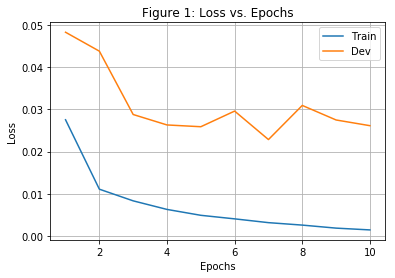

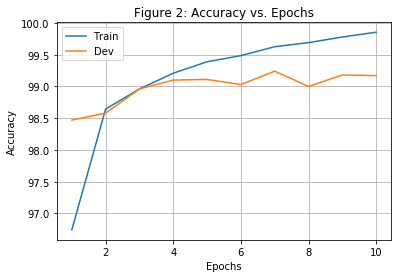

In [9]:
# 5.1 Print number of parameters in the model
#************************************#
MAX_PARAMS = 1000000
print("Total number of parameters in the model: {}, less than max params: {}".\
      format(model.count_params(), model.count_params() < MAX_PARAMS))
#************************************#

def make_plt(x,y, z, x_lbl, y_lbl, title):
    fig, ax = plt.subplots()
    train_plt, = ax.plot(x, y, label="Train")
    dev_plt, = ax.plot(x, z, label="Dev")
    ax.set(xlabel=x_lbl, ylabel=y_lbl,
           title=title)
    plt.legend(handles=[train_plt, dev_plt])
    ax.grid()
    return fig, ax


# 5.2 Summarize history for loss and make loss vs.epoch plot
#************************************#

def mat_loss_epoch(training_metrics: list):
    epochs = []
    train_loss_values = []
    dev_loss_values = []
    
    for item in training_metrics:
        
        if item["set_type"] == "train":
            train_loss_values.append(item["loss"])
            epochs.append(item["epoch"])
        
        elif item["set_type"] == "dev":
            dev_loss_values.append(item["loss"])
        
        else:
            raise("Wrong set type: {}".format(item.get("set_type")))

    m = np.array([epochs, train_loss_values, dev_loss_values])
    return m


m_loss = mat_loss_epoch(training_metrics)
fig1, ax1 = make_plt(m_loss[0,:], m_loss[1,:], m_loss[2,:], 
         "Epochs", "Loss", "Figure 1: Loss vs. Epochs")


#************************************#

# 5.3 Summarize history for accuracy and make accuracy vs.epoch plot
#************************************#

def mat_accuracy_epoch(training_metrics: list):
    epochs = []
    train_accuracy = []
    dev_accuracy = []
    
    for item in training_metrics:
        
        if item["set_type"] == "train":
            train_accuracy.append(
                100.0 * item["n_correct"] / item["n_instances"]
            )
            epochs.append(item["epoch"])
        
        elif item["set_type"] == "dev":
            dev_accuracy.append(
                100.0 * item["n_correct"] / item["n_instances"]
            )
        
        else:
            raise("Wrong set type: {}".format(item.get("set_type")))
            
    m = np.array([epochs, train_accuracy, dev_accuracy])
    return m

m_accu = mat_accuracy_epoch(training_metrics)
fig2, ax2 = make_plt(m_accu[0,:], m_accu[1,:], m_accu[2,:], 
         "Epochs", "Accuracy", "Figure 2: Accuracy vs. Epochs")

fig1.savefig("imgs/fig1.png")
fig2.savefig("imgs/fig2.png")

#************************************#

plt.show()

### 5. Varying dropout probabilities

In [10]:
# Set the probabilities of your dropout layers to 10 equally-spaced valuesp∈[0,1], 
# train for 1 epoch and report the final model accuracies for each.
#************************************#


hyperparams["epochs"] = 1
for i in range(11):
    
    p = round(0.1 * i,2)
    print("Dropout probability: {}".format(round(p,2)))
    model = ConvNet(num_classes, p).to(device)
    training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                                   train_loader, test_loader)

#************************************#

Dropout probability: 0.0
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.409435
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.523651
Train => Average loss: 0.5871, Accuracy: 3825/60000 (6.38%)
Dev => Average loss: 2.3494, Accuracy: 622/10000 (6.22%)


Dropout probability: 0.1
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382348
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.568690
Train => Average loss: 0.5876, Accuracy: 6922/60000 (11.54%)
Dev => Average loss: 2.3512, Accuracy: 1169/10000 (11.69%)


Dropout probability: 0.2
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.424675
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.414773
Train => Average loss: 0.5892, Accuracy: 6310/60000 (10.52%)
Dev => Average loss: 2.3517, Accuracy: 1220/10000 (12.20%)


Dropout probability: 0.3
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.121917
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.480909
Train => Average loss: 0.5835, Accuracy: 5693

In [11]:
# Dropout p=0.25 looks the most promising

model = ConvNet(num_classes, dropout=0.25).to(device)
hyperparams["epochs"] = 10
training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                                   train_loader, test_loader)

Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371582
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.134969
Train => Average loss: 0.5839, Accuracy: 5465/60000 (9.11%)
Dev => Average loss: 2.3252, Accuracy: 1004/10000 (10.04%)


Training/Validation Epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.378036
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.197404
Train => Average loss: 0.5839, Accuracy: 5630/60000 (9.38%)
Dev => Average loss: 2.3226, Accuracy: 1013/10000 (10.13%)


Training/Validation Epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.367991
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.255733
Train => Average loss: 0.5840, Accuracy: 5609/60000 (9.35%)
Dev => Average loss: 2.3248, Accuracy: 1001/10000 (10.01%)


Training/Validation Epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.242179
Train Epoch: 4 [40000/60000 (67%)]	Loss: 2.315333
Train => Average loss: 0.5840, Accuracy: 5536/60000 (9.23%)
Dev => Average loss: 2.3242, Accuracy: 1012/10000 (10.12%)


Training/Validation Epoc

## L2 Regularization

Dropout really didn't work well with my model,
let's try L2 Regularization because the training
set is definitely overfitting.

In [12]:
hyperparams["weight_decay"] = 1e-3 * 2
hyperparams["epochs"] = 10

In [13]:
model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"],
                            momentum=hyperparams["momentum"],
                           weight_decay=hyperparams["weight_decay"])


training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                                   train_loader, test_loader)

Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.398944
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.059228
Train => Average loss: 0.0270, Accuracy: 58108/60000 (96.85%)
Dev => Average loss: 0.0392, Accuracy: 9886/10000 (98.86%)


Training/Validation Epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.011500
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.003454
Train => Average loss: 0.0125, Accuracy: 59088/60000 (98.48%)
Dev => Average loss: 0.0388, Accuracy: 9868/10000 (98.68%)


Training/Validation Epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.050898
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.036321
Train => Average loss: 0.0102, Accuracy: 59303/60000 (98.84%)
Dev => Average loss: 0.0372, Accuracy: 9889/10000 (98.89%)


Training/Validation Epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001490
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.031491
Train => Average loss: 0.0095, Accuracy: 59352/60000 (98.92%)
Dev => Average loss: 0.0343, Accuracy: 9899/10000 (98.99%)


Training/Validat

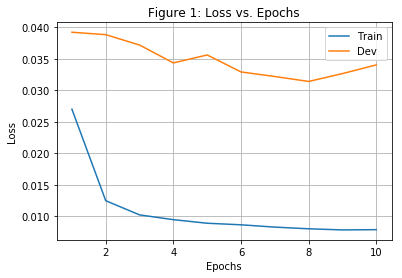

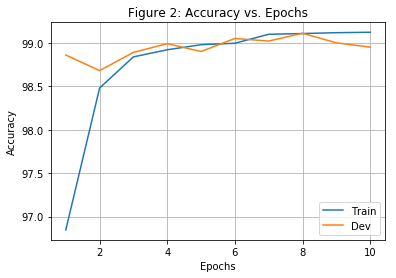

In [14]:
m_loss = mat_loss_epoch(training_metrics)
fig3, ax3 = make_plt(m_loss[0,:], m_loss[1,:], m_loss[2,:], 
             "Epochs", "Loss", "Figure 1: Loss vs. Epochs")

m_accu = mat_accuracy_epoch(training_metrics)
fig4, ax4 = make_plt(m_accu[0,:], m_accu[1,:], m_accu[2,:], 
             "Epochs", "Accuracy", "Figure 2: Accuracy vs. Epochs")

fig3.savefig("imgs/fig3.png")
fig4.savefig("imgs/fig4.png")
plt.show()

# Syncing code with GitHub

Using [AWS SageMaker](https://aws.amazon.com/sagemaker/) to host the
Jupyter notebooks and hardware. Need to Sync to GitHub from within
the notebook.

In [15]:
#!git add Assignment_One.ipynb imgs/


In [16]:
#!git commit -m "added batch norm, check output figures"

In [17]:
#!git push origin master

In [18]:
!ls

Assignment_One.ipynb	data		  hw1_solution.log  hw1_solution.tex
CS7180_Assignment1.pdf	hw1_solution.aux  hw1_solution.pdf  imgs
